<a href="https://colab.research.google.com/github/amannayak/732A74-Python/blob/master/DNN_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

# Part 1: Get the data

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

In [0]:
#latest change 1.05 Tuesday
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# 2. Load a file by ID and create local file.
downloaded = drive.CreateFile({'id':'1896GbKGCJFbqTBJJN1g03s7ZS2Q5DPMf'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('Mirai_dataset.csv') # now you can use export.csv 

In [0]:
# 2..b. Load a file by ID and create local file.
downloaded = drive.CreateFile({'id':'1zqwLJDjh6JX4x-lGKGSVEFcN5Y4wIHLj'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('mirai_labels.csv') # now you can use export.csv 



In [0]:
#testimp = np.genfromtxt('Mirai_dataset.csv')

# Part 2: Get a graphics card

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [0]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

#print(physical_devices)

tf.config.experimental.set_memory_growth(physical_devices[0], True) 

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on.

Question 1: What graphics card is available in the cloud machine? Run 'nvidia-smi' in the terminal. 

Performed on Google Colab

Question 2: Google the name of the graphics card, how many CUDA cores does it have?
Graphic Card Name : Tesla K80 GPU with 4992 CUDA cores

Question 3: How much memory does the graphics card have?
24 GB DDR5 

Question 4: What is stored in the GPU memory while training a DNN ?
Matrix operations are stored in GPU memory 

Question 5: What CPU is available in the cloud machine? How many cores does it have? Run 'lscpu' in the terminal.

CPU : Intel(R) Xeon(R) CPU @ 2.00GHz
Core : 1 


Question 6: How much CPU memory (RAM) is available in the cloud machine? Run 'free -g' in the terminal.

10 GB


# Part 4: Load the data

Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. 

We will use the function `genfromtxt` to load the data.

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.




In [0]:
from numpy import genfromtxt
import numpy as np

# Load data from file
# X = covariates, Y = labels
X = np.genfromtxt(fname = "Mirai_dataset.csv" , delimiter = ",")
Y = np.genfromtxt("mirai_labels.csv", delimiter = ",")

# Save data as numpy arrays, for faster loading in future calls to this cell
np.save('Mirai_data.npy', X)
np.save('mirai_labels.npy', Y)

# Load data from numpy arrays, for faster loading
X = np.load('Mirai_data.npy')
Y = np.load('mirai_labels.npy')
   

In [0]:
# Load data from numpy arrays, for faster loading
import numpy as np
X = np.load('Mirai_data.npy')
Y = np.load('mirai_labels.npy')

In [6]:
X.shape

(764137, 116)

In [12]:
# Remove the first 24 covariates

X = X[ : ,24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class

#print(X[1:10,])

The covariates have size (764137, 92).
The labels have size (764137,).


# Part 5: How good is a naive classifier?

Question 7: Given the distribution of examples, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by random chance.

In [0]:
#X[X == "nan"]

In [13]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
nanCheckY = np.isnan(Y)
nanCheckX = np.isnan(X)

# Print the number of NaNs (not a number) in the labels
print(f"Total nan in labels {len(nanCheckY[nanCheckY == True])}")

# Print the number of NaNs in the covariates
print(f"Total nan in covariates {len(nanCheckX[nanCheckX == True])}")


Total nan in labels 0
Total nan in covariates 0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [0]:
# Convert covariates to floats
X.astype(float)

# Convert labels to ints
Y.astype(int)

# Remove mean of each covariate (column)
XMean = np.mean(X , axis = 0)



In [11]:
XMean[0]

143.84970417901397

In [0]:
for i in range(0, len(XMean)):
  X[ : , i] = X[ : , i] - XMean[i]
  
# Divide each covariate (column) by its standard deviation

Xstd = np.std(X , axis = 0)

for i in range(0, len(Xstd)):
  X[ : , i] = X[ : , i] / Xstd[i]

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std


In [0]:
newMean = np.abs(np.around(np.mean(X , axis=0) , decimals= 4))
newSD = np.around(np.std(X , axis= 0 ) , decimals= 1)

In [13]:
newMean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
newSD

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
X.shape

(764137, 68)

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)


In [0]:
nTrain = round(X.shape[0] * .7)

In [18]:
X.shape

(764137, 92)

In [18]:
# Your code
Xtrain = X[0:nTrain , :]
Xtemp = X[(nTrain+1) : , :]

Ytrain = Y[0:nTrain]
Ytemp = Y[(nTrain+1) :]

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))




Xtrain has size (534896, 68).
Ytrain has size (534896,).
Xtemp has size (229240, 68).
Ytemp has size (229240,).


In [19]:
# Print the number of examples of each class, for the training data and the remaining 30%
print(Xtrain[0:1 , :])
#print(Ytrain[0:1])

print("test data")
print(Xtemp[0:1 , :])
# print(Ytemp[0:3])

print("diff")
print(Xtrain[0:1 , :] - Xtemp[0:1, :])

NameError: ignored

# Part 8: Number of examples per class

Question 8: Can we use the dataset as it is? Why not?

Lets randomly shuffle the data, to get some examples of each class in training data and in the remaining 30%. Use the function `shuffle` in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html

We can not use same data as training need to cover complete possible nature of data while unshuffled data might not be able to cover that. 


In [20]:
from sklearn.utils import shuffle

# Randomly shuffle data, to get both classes in training and testing
XShuffled , YShuffled = shuffle(X , Y , random_state = 0)

# Divide the data into training and validation/test again
Xtrain = XShuffled[0:nTrain , :]
Xtemp = XShuffled[(nTrain+1) : , :]

Ytrain = YShuffled[0:nTrain]
Ytemp = YShuffled[(nTrain+1) :]

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%

print(Xtrain[0:1 , :])
print(Ytrain[0:1])

print("test data")
print(Xtemp[0:1 , :])
print(Ytemp[0:1])



Xtrain has size (534896, 92).
Ytrain has size (534896,).
Xtemp has size (229240, 92).
Ytemp has size (229240,).
[[-8.77664822e-02  6.30481424e-01 -4.50531913e-01 -1.71454092e-01
   7.14065482e-01 -4.60324659e-01 -2.13068153e-01 -2.16138179e-01
  -3.23979539e-01 -1.81131783e-01 -4.00504624e-01 -2.19991906e-02
  -2.32010868e-02 -4.72374129e-02 -2.96060509e-01 -3.25232006e-01
  -2.09734584e-01 -4.01746566e-01 -2.72671940e-02 -3.22351108e-02
  -7.36250544e-02 -2.54863387e-01 -3.28327853e-01 -2.56810826e-01
  -4.05537676e-01 -4.07783408e-02 -6.46380722e-02 -1.25430254e-01
   8.01237927e-02 -3.30051596e-01 -3.39951689e-01 -4.08619016e-01
  -5.72305998e-02 -1.61069367e-01 -1.96777880e-01  2.56061475e-01
  -3.28292426e-01 -3.43749328e-01 -4.07589072e-01 -5.02286258e-02
  -2.22689854e-01 -2.36792137e-01 -2.16138179e-01 -2.41812747e-02
  -1.57962912e-02 -2.96060509e-01 -2.57839499e-02 -2.30898139e-02
  -2.54863387e-01 -3.22489600e-02 -3.59076403e-02  8.01237927e-02
  -5.32304384e-02 -7.53219640e

#  Part 9: Split non-training data data into validation and test
Split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [21]:
from sklearn.model_selection import train_test_split

Xval , Xtest , Yval , Ytest  = train_test_split(Xtemp , Ytemp , test_size = .5 , random_state = 42)


print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114620, 92), (114620, 92), (114620,) and (114620,)


# Part 10: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [42]:
#

2.3.1


In [0]:
#from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.layers import BatchNormalization
from keras.layers import Dropout
#from tensorflow.keras.models import Sequential 

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)
def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, use_bn=False, use_dropout=False, use_custom_dropout=False , dRate = 0):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == "sgd":
      optimized = SGD(lr=learning_rate)
    elif optimizer == 'Adam':
      optimized = Adam(lr=learning_rate,beta_1=0.9,beta_2=0.999,amsgrad=False)
    

    # Setup a sequential model
    #model = tf.keras.Sequential()
    model = Sequential()
    # Add layers to the model, using the input parameters of the build_DNN function
    model.add(Dense(n_nodes,kernel_initializer='uniform',input_shape=(input_shape[1],),activation=act_fun))
    if use_dropout == True:
      model.add(Dropout(rate = dRate))
    if use_bn == True:
      BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
    if use_custom_dropout == True:
      model.add(myDropout(dRate))
    # Add first layer, requires input shape
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes,kernel_initializer='uniform',activation=act_fun))           
        if use_bn == True:
          BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
        if use_dropout == True:
          model.add(Dropout(rate = dRate))
        if use_custom_dropout == True:
          model.add(myDropout(dRate))      

    # Final layer
    model.add(Dense(1,activation=act_fun))

    
    # Compile model
    model.compile(optimizer=optimized,loss= "binary_crossentropy",metrics=['accuracy'])
    
    return model

In [0]:
# Lets define a help function for plotting the training results

# IMPORTANT NOTE
# The history unfortunately behaves a bit randomly for every user
# If the plots for accuracy and loss look mixed, change the order of
# val_loss, val_acc, loss, acc
# until the plots look as they "should"

import matplotlib.pyplot as plt
def plot_results(history):
    val_loss, val_acc, loss, acc = history.history.values()

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 11: Train the DNN

Time to train the DNN, we start simple with 2 layers with 2 nodes each, learning rate 0.1.

### 2 layers, 20 nodes

In [24]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build the model
model1 = build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='sgd', learning_rate=0.1)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval))

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 53s 100us/step - loss: 0.1619 - accuracy: 0.9142 - val_loss: 0.1483 - val_accuracy: 0.9207
Epoch 2/20
534896/534896 [==============================] - 51s 96us/step - loss: 0.1455 - accuracy: 0.9213 - val_loss: 0.1459 - val_accuracy: 0.9211
Epoch 3/20
534896/534896 [==============================] - 52s 98us/step - loss: 0.1411 - accuracy: 0.9242 - val_loss: 0.1389 - val_accuracy: 0.9264
Epoch 4/20
534896/534896 [==============================] - 53s 98us/step - loss: 0.1375 - accuracy: 0.9267 - val_loss: 0.1348 - val_accuracy: 0.9287
Epoch 5/20
534896/534896 [==============================] - 53s 99us/step - loss: 0.1335 - accuracy: 0.9293 - val_loss: 0.1356 - val_accuracy: 0.9242
Epoch 6/20
534896/534896 [==============================] - 53s 99us/step - loss: 0.1293 - accuracy: 0.9318 - val_loss: 0.1281 - val_accuracy: 0.9319
Epoch 7/20
534896/534896 [=====================

In [25]:
# Evaluate the model on the test data
#pred = model1.predict(Xtest)
#score = 
score = model1.evaluate(Xtest , Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 5s 46us/step
Test loss: 0.1206
Test accuracy: 0.9301


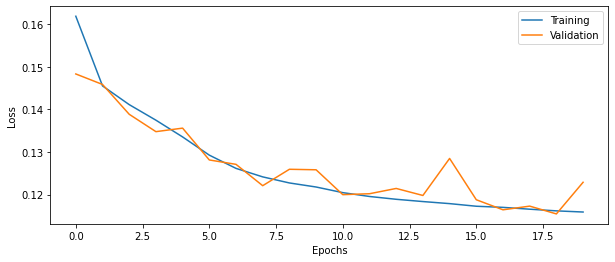

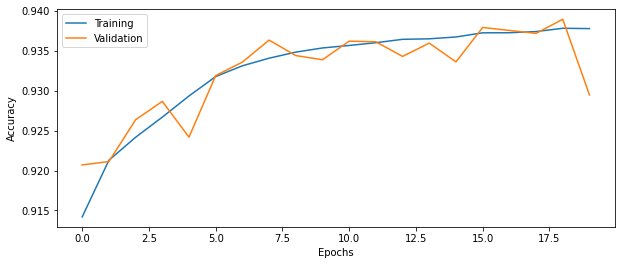

In [27]:
## Plot the history from the training run
plot_results(history1)

# Part 12: More questions

Question 9: What happens if you add several Dense layers without specifying the activation function?

Question 10: How are the weights in each dense layer initialized as default? How are the bias weights initialized?


# Part 13: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [28]:
from sklearn.utils import class_weight

# Calculate class weights
classes = np.unique(Ytrain)
weights = {classes[i]:class_weight.compute_class_weight('balanced',classes,Ytrain)[i] for i in range(0,len(classes))}
# Print the class weights
weights

{0.0: 3.146076932125632, 1.0: 0.59447949035978}

### 2 layers, 20 nodes, class weights

In [29]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model2 = build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='sgd',learning_rate=0.1)


history2 = model2.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 51s 96us/step - loss: 0.1768 - accuracy: 0.9101 - val_loss: 0.2228 - val_accuracy: 0.9163
Epoch 2/20
534896/534896 [==============================] - 50s 93us/step - loss: 0.1597 - accuracy: 0.9175 - val_loss: 0.2010 - val_accuracy: 0.9172
Epoch 3/20
534896/534896 [==============================] - 50s 93us/step - loss: 0.1557 - accuracy: 0.9180 - val_loss: 0.2004 - val_accuracy: 0.9184
Epoch 4/20
534896/534896 [==============================] - 50s 93us/step - loss: 0.1512 - accuracy: 0.9195 - val_loss: 0.2020 - val_accuracy: 0.9196
Epoch 5/20
534896/534896 [==============================] - 49s 92us/step - loss: 0.1466 - accuracy: 0.9224 - val_loss: 0.1690 - val_accuracy: 0.9262
Epoch 6/20
534896/534896 [==============================] - 50s 94us/step - loss: 0.1428 - accuracy: 0.9257 - val_loss: 0.1844 - val_accuracy: 0.9277
Epoch 7/20
534896/534896 [======================

In [30]:
# Evaluate model on test data
score = model2.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 5s 47us/step
Test loss: 0.1501
Test accuracy: 0.9352


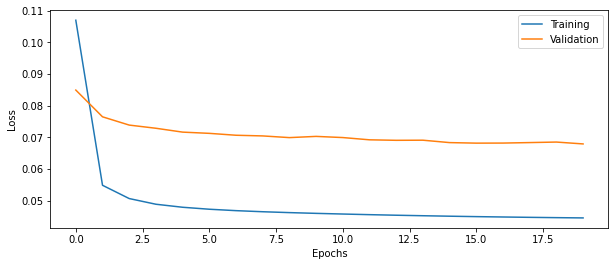

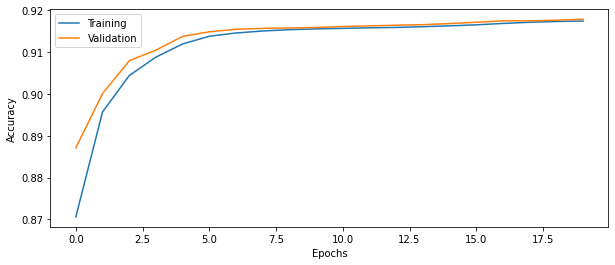

In [34]:
plot_results(history2)

# Part 14: More questions

Question 11: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the cloud computer a few times during training.

Question 13: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 14: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Question 15: What limits how large the batch size can be?

Question 16: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 15: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 17: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

### 4 layers, 20 nodes, class weights

In [32]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape =Xtrain.shape
# Build and train model
model3 = build_DNN(input_shape,4,20,'sigmoid','sgd',0.1)
model3.summary()
history3 = model3.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                1860      
_________________________________________________________________
dense_13 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_14 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_15 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 21        
Total params: 3,141
Trainable params: 3,141
Non-trainable params: 0
_________________________________________________________________
Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 57s 10

In [33]:
# Evaluate model on test data
score = model3.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 6s 51us/step
Test loss: 0.2066
Test accuracy: 0.9224


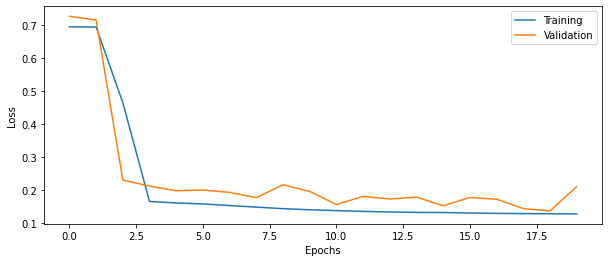

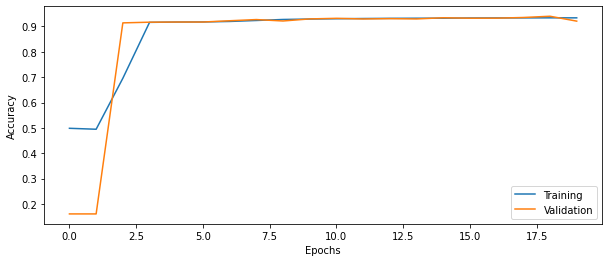

In [34]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [35]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model4 = build_DNN(input_shape,2,50,'sigmoid','sgd',0.1)

history4 = model4.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 52s 98us/step - loss: 0.1760 - accuracy: 0.9103 - val_loss: 0.1795 - val_accuracy: 0.9161
Epoch 2/20
534896/534896 [==============================] - 52s 97us/step - loss: 0.1608 - accuracy: 0.9174 - val_loss: 0.2097 - val_accuracy: 0.9171
Epoch 3/20
534896/534896 [==============================] - 52s 97us/step - loss: 0.1565 - accuracy: 0.9180 - val_loss: 0.1631 - val_accuracy: 0.9187
Epoch 4/20
534896/534896 [==============================] - 52s 98us/step - loss: 0.1520 - accuracy: 0.9188 - val_loss: 0.2069 - val_accuracy: 0.9188
Epoch 5/20
534896/534896 [==============================] - 51s 95us/step - loss: 0.1473 - accuracy: 0.9215 - val_loss: 0.1743 - val_accuracy: 0.9234
Epoch 6/20
534896/534896 [==============================] - 52s 98us/step - loss: 0.1420 - accuracy: 0.9253 - val_loss: 0.1750 - val_accuracy: 0.9281
Epoch 7/20
534896/534896 [======================

In [36]:
# Evaluate model on test data
score = model4.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 5s 47us/step
Test loss: 0.1547
Test accuracy: 0.9362


In [0]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [37]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtest.shape

# Build and train model
model5 = build_DNN(input_shape=input_shape,n_layers=4,n_nodes=50,act_fun='sigmoid',optimizer='sgd',learning_rate=0.1)

history5 = model5.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 57s 107us/step - loss: 0.6957 - accuracy: 0.4993 - val_loss: 0.7099 - val_accuracy: 0.1606
Epoch 2/20
534896/534896 [==============================] - 58s 108us/step - loss: 0.5687 - accuracy: 0.6207 - val_loss: 0.2095 - val_accuracy: 0.9131
Epoch 3/20
534896/534896 [==============================] - 57s 107us/step - loss: 0.1678 - accuracy: 0.9153 - val_loss: 0.2068 - val_accuracy: 0.9174
Epoch 4/20
534896/534896 [==============================] - 58s 109us/step - loss: 0.1617 - accuracy: 0.9175 - val_loss: 0.2061 - val_accuracy: 0.9174
Epoch 5/20
534896/534896 [==============================] - 57s 107us/step - loss: 0.1585 - accuracy: 0.9179 - val_loss: 0.2191 - val_accuracy: 0.9174
Epoch 6/20
534896/534896 [==============================] - 57s 107us/step - loss: 0.1544 - accuracy: 0.9186 - val_loss: 0.1858 - val_accuracy: 0.9190
Epoch 7/20
534896/534896 [================

In [38]:
# Evaluate model on test data
score = model5.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 6s 50us/step
Test loss: 0.1632
Test accuracy: 0.9342


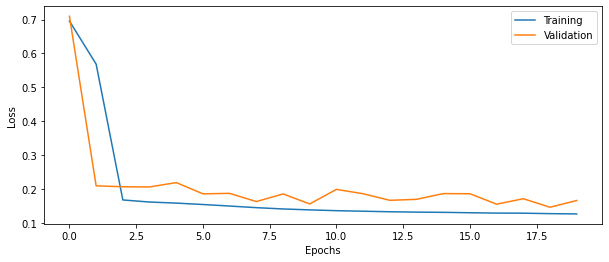

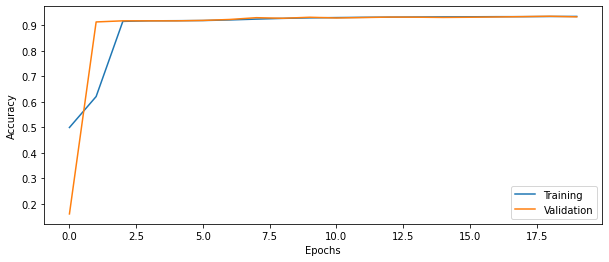

In [39]:
plot_results(history5)

# Part 16: Batch normalization

Now add batch normalization after each dense layer. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 18: Why is batch normalization important when training deep networks?

### 2 layers, 20 nodes, class weights, batch normalization

In [40]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model6 = build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='sgd',learning_rate=0.1,use_bn=True)

history6 = model6.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 51s 95us/step - loss: 0.1767 - accuracy: 0.9105 - val_loss: 0.1920 - val_accuracy: 0.9169
Epoch 2/20
534896/534896 [==============================] - 52s 96us/step - loss: 0.1598 - accuracy: 0.9174 - val_loss: 0.2228 - val_accuracy: 0.9168
Epoch 3/20
534896/534896 [==============================] - 52s 97us/step - loss: 0.1547 - accuracy: 0.9180 - val_loss: 0.2096 - val_accuracy: 0.9175
Epoch 4/20
534896/534896 [==============================] - 51s 94us/step - loss: 0.1498 - accuracy: 0.9200 - val_loss: 0.1646 - val_accuracy: 0.9262
Epoch 5/20
534896/534896 [==============================] - 51s 95us/step - loss: 0.1454 - accuracy: 0.9230 - val_loss: 0.1902 - val_accuracy: 0.9229
Epoch 6/20
534896/534896 [==============================] - 52s 97us/step - loss: 0.1422 - accuracy: 0.9256 - val_loss: 0.1836 - val_accuracy: 0.9242
Epoch 7/20
534896/534896 [======================

In [41]:
# Evaluate model on test data
score = model6.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 5s 47us/step
Test loss: 0.1454
Test accuracy: 0.9362


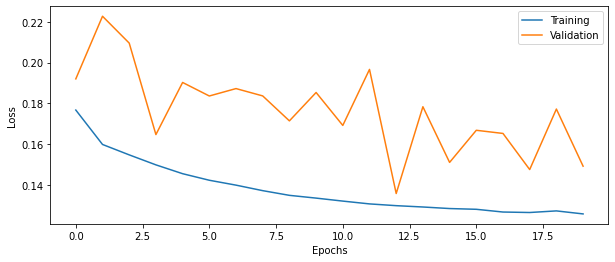

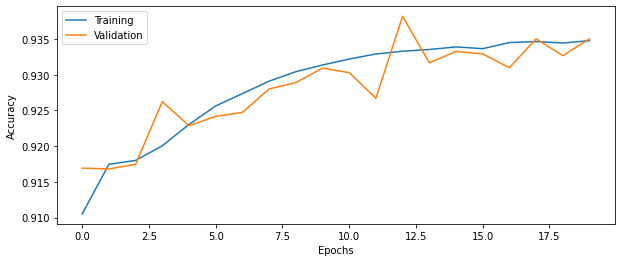

In [42]:
plot_results(history6)

# Part 17: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [47]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model7 = build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='relu',optimizer='sgd',learning_rate=0.1)

history7 = model7.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 52s 98us/step - loss: 7.6665 - accuracy: 5.6086e-06 - val_loss: 2.4494 - val_accuracy: 0.0000e+00
Epoch 2/20
534896/534896 [==============================] - 51s 96us/step - loss: 7.6666 - accuracy: 0.0000e+00 - val_loss: 2.4494 - val_accuracy: 0.0000e+00
Epoch 3/20
534896/534896 [==============================] - 52s 96us/step - loss: 7.6666 - accuracy: 0.0000e+00 - val_loss: 2.4494 - val_accuracy: 0.0000e+00
Epoch 4/20
534896/534896 [==============================] - 53s 99us/step - loss: 7.6666 - accuracy: 0.0000e+00 - val_loss: 2.4494 - val_accuracy: 0.0000e+00
Epoch 5/20
534896/534896 [==============================] - 54s 102us/step - loss: 7.6666 - accuracy: 0.0000e+00 - val_loss: 2.4494 - val_accuracy: 0.0000e+00
Epoch 6/20
534896/534896 [==============================] - 52s 98us/step - loss: 7.6666 - accuracy: 0.0000e+00 - val_loss: 2.4494 - val_accuracy: 0.0000e+00

In [48]:
# Evaluate model on test data
score = model7.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 6s 49us/step
Test loss: 2.4214
Test accuracy: 0.0000


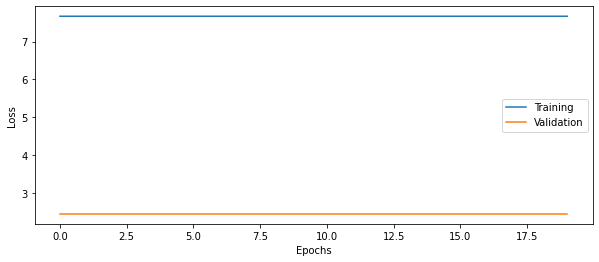

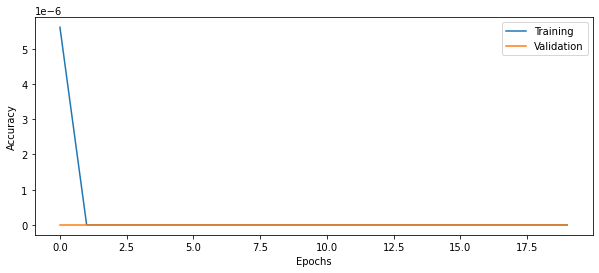

In [49]:
plot_results(history7)

# Part 18: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [50]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model8 = build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='Adam',learning_rate=0.1,use_bn=False)

history8 = model8.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 66s 124us/step - loss: 0.1865 - accuracy: 0.9075 - val_loss: 0.2598 - val_accuracy: 0.9104
Epoch 2/20
534896/534896 [==============================] - 65s 122us/step - loss: 0.1790 - accuracy: 0.9114 - val_loss: 0.2157 - val_accuracy: 0.9134
Epoch 3/20
534896/534896 [==============================] - 65s 121us/step - loss: 0.1746 - accuracy: 0.9121 - val_loss: 0.1988 - val_accuracy: 0.9146
Epoch 4/20
534896/534896 [==============================] - 64s 119us/step - loss: 0.1734 - accuracy: 0.9135 - val_loss: 0.2206 - val_accuracy: 0.9129
Epoch 5/20
534896/534896 [==============================] - 64s 119us/step - loss: 0.1742 - accuracy: 0.9133 - val_loss: 0.2359 - val_accuracy: 0.9133
Epoch 6/20
534896/534896 [==============================] - 65s 121us/step - loss: 0.1746 - accuracy: 0.9126 - val_loss: 0.2022 - val_accuracy: 0.9145
Epoch 7/20
534896/534896 [================

In [54]:
# Evaluate model on test data
score = model8.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 6s 48us/step
Test loss: 0.2275
Test accuracy: 0.9161


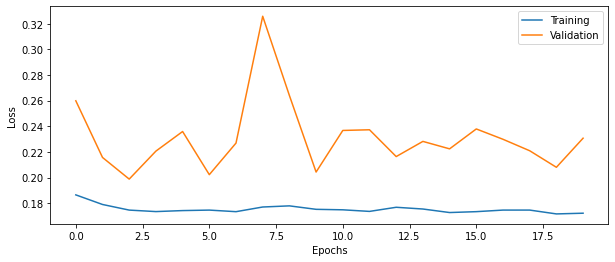

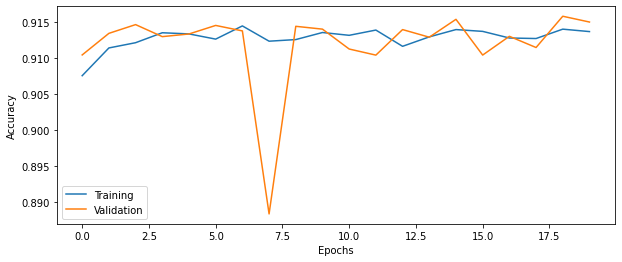

In [55]:
plot_results(history8)

# Part 19: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer), with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/layers/core/ for how the Dropout layer works.

---

Question 19: How does the validation accuracy change when adding dropout?

Question 20: How does the test accuracy change when adding dropout?

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [59]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
#model9 =  build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='Adam',use_bn=False, use_dropout = True , drate = 0.50  )

model9 = build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='sgd',learning_rate=0.1,use_bn=False, use_dropout = True , dRate = 0.50)

history9 = model9.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 59s 110us/step - loss: 0.2175 - accuracy: 0.8897 - val_loss: 0.2284 - val_accuracy: 0.9123
Epoch 2/20
534896/534896 [==============================] - 58s 108us/step - loss: 0.1812 - accuracy: 0.9097 - val_loss: 0.2163 - val_accuracy: 0.9147
Epoch 3/20
534896/534896 [==============================] - 58s 108us/step - loss: 0.1775 - accuracy: 0.9113 - val_loss: 0.2118 - val_accuracy: 0.9143
Epoch 4/20
534896/534896 [==============================] - 57s 106us/step - loss: 0.1772 - accuracy: 0.9113 - val_loss: 0.2177 - val_accuracy: 0.9146
Epoch 5/20
534896/534896 [==============================] - 58s 108us/step - loss: 0.1756 - accuracy: 0.9118 - val_loss: 0.2146 - val_accuracy: 0.9149
Epoch 6/20
534896/534896 [==============================] - 59s 110us/step - loss: 0.1757 - accuracy: 0.9118 - val_loss: 0.2146 - val_accuracy: 0.9141
Epoch 7/20
534896/534896 [================

In [60]:
# Evaluate model on test data
score = model9.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114620/114620 [==============================] - 6s 54us/step
Test loss: 0.2072
Test accuracy: 0.9178


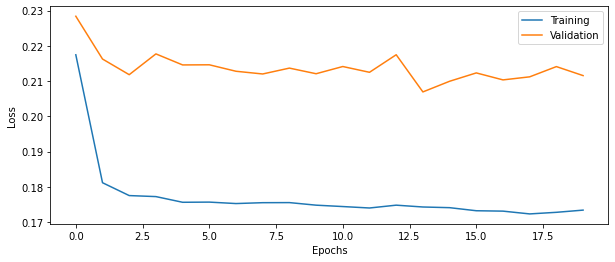

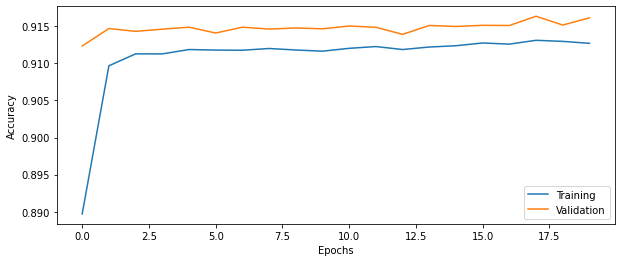

In [61]:
plot_results(history9)

# Part 20: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 21: How high classification accuracy can you achieve for the test data? What is your best configuration?

In [69]:
# Find your best configuration for the DNN
batch_size = 10000
epochs = 10
input_shape = Xtrain.shape

# Build and train model
model10 = build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='sgd',learning_rate=0.1,use_bn=True)

history10 = model10.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/10
534896/534896 [==============================] - 52s 97us/step - loss: 0.1782 - accuracy: 0.9099 - val_loss: 0.2258 - val_accuracy: 0.9162
Epoch 2/10
534896/534896 [==============================] - 52s 97us/step - loss: 0.1611 - accuracy: 0.9174 - val_loss: 0.1978 - val_accuracy: 0.9175
Epoch 3/10
534896/534896 [==============================] - 52s 97us/step - loss: 0.1567 - accuracy: 0.9179 - val_loss: 0.2024 - val_accuracy: 0.9176
Epoch 4/10
534896/534896 [==============================] - 53s 100us/step - loss: 0.1517 - accuracy: 0.9192 - val_loss: 0.1901 - val_accuracy: 0.9195
Epoch 5/10
534896/534896 [==============================] - 53s 98us/step - loss: 0.1473 - accuracy: 0.9219 - val_loss: 0.1634 - val_accuracy: 0.9278
Epoch 6/10
534896/534896 [==============================] - 52s 97us/step - loss: 0.1432 - accuracy: 0.9247 - val_loss: 0.1485 - val_accuracy: 0.9296
Epoch 7/10
534896/534896 [=====================

114620/114620 [==============================] - 5s 47us/step
Test loss: 0.1683
Test accuracy: 0.9316


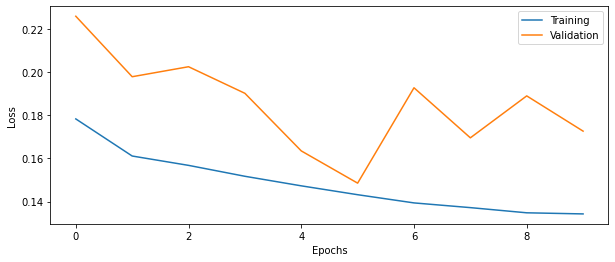

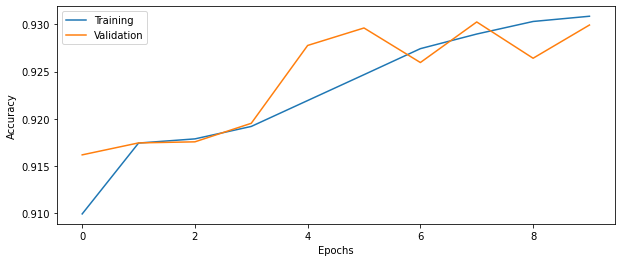

In [70]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

plot_results(history10)

# Part 21: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 22: What is the mean and the standard deviation of the test accuracy?

In [0]:
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs


        

### Your best config, custom dropout

In [74]:
# Your best training parameters
batch_size = 10000
epochs = 10
input_shape = Xtrain.shape

# Build and train model
model11 = build_DNN(input_shape=input_shape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='sgd',learning_rate=0.1,use_bn=True, use_custom_dropout = True , dRate = 0.5)

history11 = model11.fit(Xtrain,Ytrain,epochs=epochs,validation_data=(Xval,Yval),class_weight=weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/10
534896/534896 [==============================] - 56s 104us/step - loss: 0.2124 - accuracy: 0.8924 - val_loss: 0.2296 - val_accuracy: 0.9059
Epoch 2/10
534896/534896 [==============================] - 57s 106us/step - loss: 0.1815 - accuracy: 0.9093 - val_loss: 0.2253 - val_accuracy: 0.9103
Epoch 3/10
534896/534896 [==============================] - 55s 102us/step - loss: 0.1777 - accuracy: 0.9110 - val_loss: 0.2286 - val_accuracy: 0.9100
Epoch 4/10
534896/534896 [==============================] - 54s 102us/step - loss: 0.1773 - accuracy: 0.9113 - val_loss: 0.2266 - val_accuracy: 0.9103
Epoch 5/10
534896/534896 [==============================] - 54s 101us/step - loss: 0.1764 - accuracy: 0.9117 - val_loss: 0.2266 - val_accuracy: 0.9117
Epoch 6/10
534896/534896 [==============================] - 54s 101us/step - loss: 0.1749 - accuracy: 0.9125 - val_loss: 0.2255 - val_accuracy: 0.9120
Epoch 7/10
534896/534896 [================

114620/114620 [==============================] - 6s 51us/step
Test loss: 0.2199
Test accuracy: 0.9142


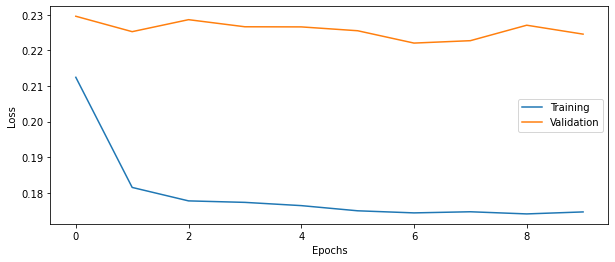

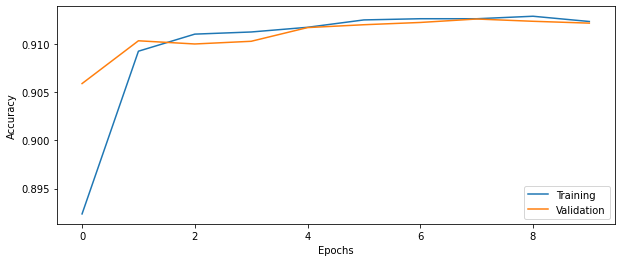

In [75]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data

score = model11.evaluate(Xtest , Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

plot_results(history11)

In [0]:
# Run the testing 100 times, and save the accuracies in an array

    
# Calculate and print mean and std of accuracies



# Part 22: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 23: What is the mean and the standard deviation of the test accuracy?

Question 24: What is the main advantage of dropout compared to CV for estimating test uncertainty?

In [85]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation

# Loop over cross validation folds
    
    # Calculate class weights for current split
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    
    # Fit the model with training set and class weights for this fold
    
    # Evaluate the model using the test set for this fold
    
    # Save the test accuracy in an array

# Calculate and print mean and std of accuracies

skf = StratifiedKFold(n_splits = 10 , shuffle = False, random_state = 1234)



accAr = []
i = 1
for train_idx , test_idx in skf.split(X,Y):
  print(f"Number of fold is {i}")
  train_X = X[train_idx , : ]
  train_Y = Y[train_idx]

  test_X = X[test_idx, : ]
  test_Y = Y[test_idx]
    classes = np.unique(train_Y)
  weights = {classes[i]:class_weight.compute_class_weight('balanced',classes,train_Y)[i] for i in range(0,len(classes))}

  ipShape = train_X.shape

  batch_size = 100
  epochs = 1
  
  modelCV = build_DNN(input_shape=ipShape,n_layers=2,n_nodes=20,act_fun='sigmoid',optimizer='sgd',learning_rate=0.1,use_bn=True)

  historyCV = modelCV.fit(train_X,train_Y,epochs=epochs,class_weight=weights, verbose = 0) 

  score = modelCV.evaluate(Xtest,Ytest, verbose = 0)

  accAr.append(score[2])
  i = i + 1




Number of fold is 1


IndexError: ignored

In [0]:
import statistics as stat
meanVal = stat.mean(accAr)
std = variance(accAr)


# Part 23: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 25: How would you change the DNN in order to use it for regression instead?

Since we are interested in regression, we need to change activation functioin of output layer to linear activation function as current activation function will change it into 0 and 1 while with that, any value outside that range would not be achieved.  

## Report

Send in this jupyter notebook, with answers to all questions.